### 1. Imports e carregamento dos dados

In [303]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor


In [200]:

url = 'https://raw.githubusercontent.com/RonaldoBispoLima/Top-1000-Movies-by-IMDB-Rating/refs/heads/main/Top_1000_Movies_by_IMDB_Rating.csv'
df_bruto = pd.read_csv(url, index_col=0)

### 2. Análise Exploratória e Limpeza e Tratamento

In [201]:
df_bruto.head(3)

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"


In [202]:
df_bruto.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, 1 to 999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   999 non-null    object 
 1   Released_Year  999 non-null    object 
 2   Certificate    898 non-null    object 
 3   Runtime        999 non-null    object 
 4   Genre          999 non-null    object 
 5   IMDB_Rating    999 non-null    float64
 6   Overview       999 non-null    object 
 7   Meta_score     842 non-null    float64
 8   Director       999 non-null    object 
 9   Star1          999 non-null    object 
 10  Star2          999 non-null    object 
 11  Star3          999 non-null    object 
 12  Star4          999 non-null    object 
 13  No_of_Votes    999 non-null    int64  
 14  Gross          830 non-null    object 
dtypes: float64(2), int64(1), object(12)
memory usage: 124.9+ KB


In [203]:
df_bruto.describe()

,IMDB_Rating,Meta_score,No_of_Votes
count,999.000000,842.000000,9.990000e+02
mean,7.947948,77.969121,2.716214e+05
std,0.272290,12.383257,3.209126e+05
min,7.600000,28.000000,2.508800e+04
25%,7.700000,70.000000,5.547150e+04
50%,7.900000,79.000000,1.383560e+05
75%,8.100000,87.000000,3.731675e+05
max,9.200000,100.000000,2.303232e+06


In [204]:
df_bruto.isnull().sum()

Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

In [221]:
df_tratado = df_bruto.copy()

In [222]:
def parse_runtime(x):
    try:
        if pd.isna(x): return np.nan
        m = re.search(r'(\d+)', str(x))
        return int(m.group(1)) if m else np.nan
    except:
        return np.nan

def parse_gross(x):
    try:
        if pd.isna(x): return np.nan
        return float(str(x).replace(',','').replace('$','').strip())
    except:
        return np.nan


In [ ]:
i = df_tratado[(df_tratado.Released_Year =='PG')].index
df_tratado = df_tratado.drop(i)

In [224]:

df_tratado['IMDB_Rating'] = df_tratado['IMDB_Rating']
df_tratado['Released_Year'] = pd.to_datetime(df_tratado['Released_Year'])
df_tratado['Runtime'] = df_tratado['Runtime'].apply(parse_runtime)
df_tratado['Gross'] = df_tratado['Gross'].apply(parse_gross) / 1000000
df_tratado['Meta_score'] = pd.to_numeric(df_tratado['Meta_score'], errors='coerce')
df_tratado['No_of_Votes'] = pd.to_numeric(df_tratado['No_of_Votes'], errors='coerce')

# Extrai o gênero principal
df_tratado['Genre'] = df_tratado['Genre'].apply(lambda x: str(x).split(',')[0].strip() if pd.notna(x) else 'Unknown')

df_tratado['Overview'] = df_tratado['Overview'].fillna('').apply(lambda s: re.sub(r'[^a-zA-Z0-9\s]', ' ', str(s)).lower())

#### Tratamento dos valores ausentes

In [ ]:
median_meta_score = df_tratado['Meta_score'].median()
df_tratado['Meta_score'] = df_tratado['Meta_score'].fillna(median_meta_score)

In [ ]:
mode_certificate = df_tratado['Certificate'].mode()[0]
df_tratado['Certificate'] = df_tratado['Certificate'].fillna(mode_certificate)

In [229]:
df_tratado['Gross'] = df_tratado.groupby('Genre')['Gross'].transform(
    lambda x: x.fillna(x.median())
)

d:\Projetos\Python\analise\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [ ]:
df_tratado['Gross'] = df_tratado['Gross'].fillna('0') 

In [241]:
df_tratado.isnull().sum()

Series_Title     0
Released_Year    0
Certificate      0
Runtime          0
Genre            0
IMDB_Rating      0
Overview         0
Meta_score       0
Director         0
Star1            0
Star2            0
Star3            0
Star4            0
No_of_Votes      0
Gross            0
dtype: int64

In [243]:
df_tratado.dtypes

Series_Title             object
Released_Year    datetime64[ns]
Certificate              object
Runtime                   int64
Genre                    object
IMDB_Rating             float64
Overview                 object
Meta_score              float64
Director                 object
Star1                    object
Star2                    object
Star3                    object
Star4                    object
No_of_Votes               int64
Gross                    object
dtype: object

In [244]:
df_tratado[['IMDB_Rating', 'Released_Year', 'Runtime','Gross','Meta_score','No_of_Votes','Genre','Overview']].head()

,IMDB_Rating,Released_Year,Runtime,Gross,Meta_score,No_of_Votes,Genre,Overview
1,9.2,1972-01-01,175,134.966411,100.0,1620367,Crime,an organized crime dynasty s aging patriarch t...
2,9.0,2008-01-01,152,534.858444,84.0,2303232,Action,when the menace known as the joker wreaks havo...
3,9.0,1974-01-01,202,57.3,90.0,1129952,Crime,the early life and career of vito corleone in ...
4,9.0,1957-01-01,96,4.36,96.0,689845,Crime,a jury holdout attempts to prevent a miscarria...
5,8.9,2003-01-01,201,377.845905,94.0,1642758,Action,gandalf and aragorn lead the world of men agai...


In [ ]:
genre_rating_mean = df_tratado.groupby('Genre')['IMDB_Rating'].mean().sort_values(ascending=False)

print('\nMédia de IMDB_Rating por Gênero Principal:')
print(genre_rating_mean)


Média de IMDB_Rating por Gênero Principal:
Genre
Western      8.350000
Crime        8.016822
Fantasy      8.000000
Mystery      7.975000
Film-Noir    7.966667
Drama        7.952778
Action       7.949419
Adventure    7.942254
Biography    7.938636
Animation    7.930488
Horror       7.909091
Comedy       7.901290
Family       7.800000
Thriller     7.800000
Name: IMDB_Rating, dtype: float64


In [ ]:
certificate_rating_mean = df_tratado.groupby('Certificate')['IMDB_Rating'].mean().sort_values(ascending=False)

print('\nMédia de IMDB_Rating por Certificado:')
print(certificate_rating_mean)


Média de IMDB_Rating por Certificado:
Certificate
TV-14       8.300000
16          8.100000
TV-MA       8.100000
Unrated     8.100000
Passed      8.020588
G           8.000000
A           7.992347
U           7.964371
UA          7.957143
Approved    7.945455
PG          7.927027
TV-PG       7.900000
R           7.869863
GP          7.850000
PG-13       7.797674
U/A         7.600000
Name: IMDB_Rating, dtype: float64


In [ ]:
director_counts = df_tratado['Director'].value_counts()
directors_with_enough_films = director_counts[director_counts >= 5].index

df_filtered_directors = df_tratado[df_tratado['Director'].isin(directors_with_enough_films)]

director_rating_mean = df_filtered_directors.groupby('Director')['IMDB_Rating'].mean().sort_values(ascending=False)

print('\nTop 10 Diretores com mais de 5 filmes (Média de IMDB_Rating):')
print(director_rating_mean.head(10))

print('\nTop 10 Diretores com mais de 5 filmes (Menor Média de IMDB_Rating):')
print(director_rating_mean.tail(10))


Top 10 Diretores com mais de 5 filmes (Média de IMDB_Rating):
Director
Christopher Nolan       8.462500
Francis Ford Coppola    8.400000
Peter Jackson           8.400000
Charles Chaplin         8.333333
Sergio Leone            8.266667
Stanley Kubrick         8.233333
Akira Kurosawa          8.220000
Quentin Tarantino       8.175000
Martin Scorsese         8.170000
Billy Wilder            8.144444
Name: IMDB_Rating, dtype: float64

Top 10 Diretores com mais de 5 filmes (Menor Média de IMDB_Rating):
Director
John Ford            7.900000
John Huston          7.900000
Richard Linklater    7.900000
David Lynch          7.860000
Howard Hawks         7.857143
Wes Anderson         7.833333
Rob Reiner           7.828571
Joel Coen            7.816667
Woody Allen          7.788889
Alfonso Cuarón       7.750000
Name: IMDB_Rating, dtype: float64


Recomendaria o filme *The Godfather* para uma pessoa que não conheço.

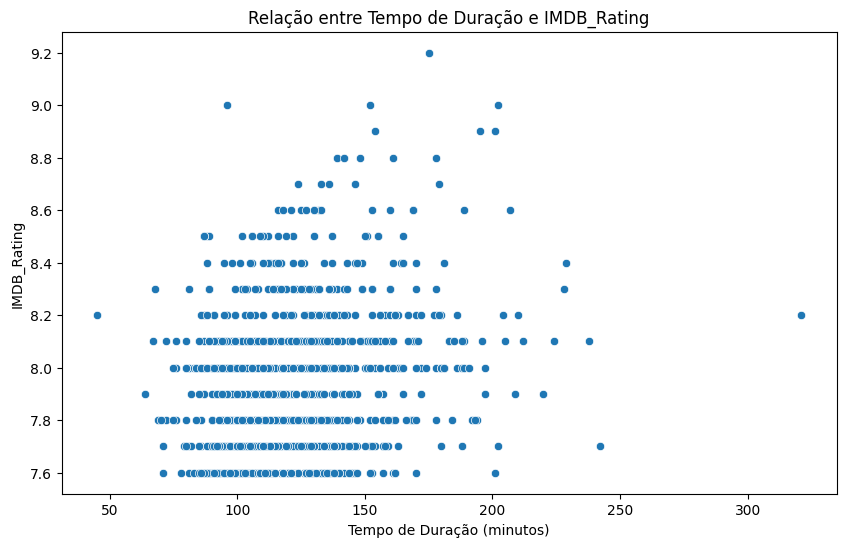


Correlação entre Runtime e IMDB_Rating: 0.24


In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Runtime', y='IMDB_Rating', data=df_tratado)
plt.title('Relação entre Tempo de Duração e IMDB_Rating')
plt.xlabel('Tempo de Duração (minutos)')
plt.ylabel('IMDB_Rating')
plt.show()

correlation_runtime_rating = df_tratado['Runtime'].corr(df_tratado['IMDB_Rating'])
print(f'\nCorrelação entre Runtime e IMDB_Rating: {correlation_runtime_rating:.2f}')

Filmes mais longos podem ter uma tendência a notas mais altas

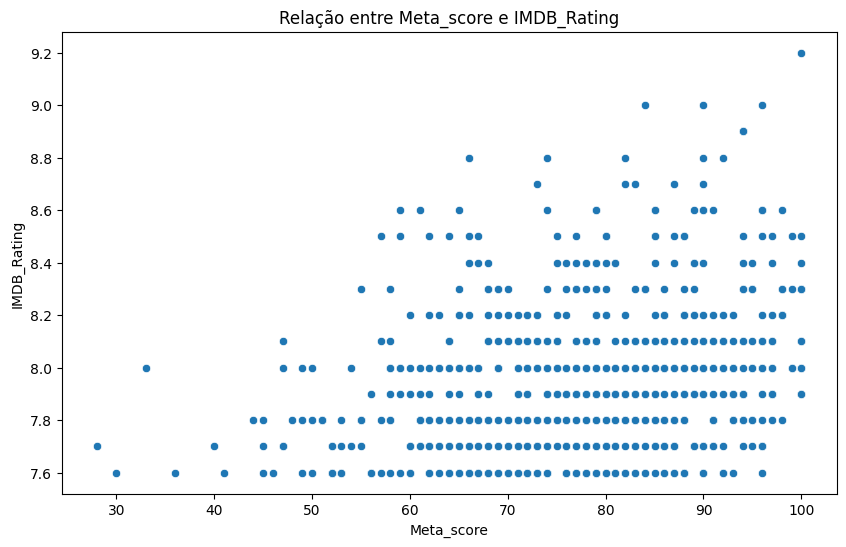


Correlação entre Meta_score e IMDB_Rating: 0.26


In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Meta_score', y='IMDB_Rating', data=df_tratado)
plt.title('Relação entre Meta_score e IMDB_Rating')
plt.xlabel('Meta_score')
plt.ylabel('IMDB_Rating')
plt.show()

correlation_meta_rating = df_tratado['Meta_score'].corr(df_tratado['IMDB_Rating'])
print(f'\nCorrelação entre Meta_score e IMDB_Rating: {correlation_meta_rating:.2f}')

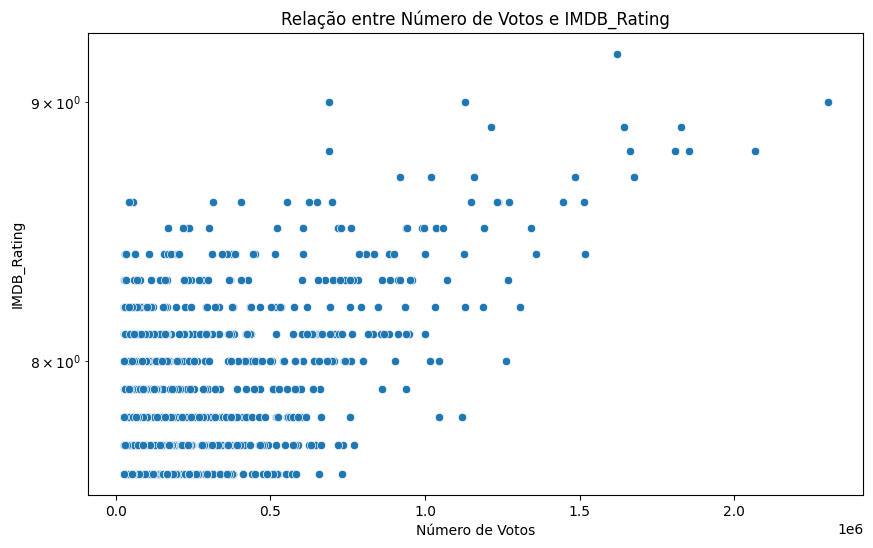


Correlação entre No_of_Votes e IMDB_Rating: 0.48


In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='No_of_Votes', y='IMDB_Rating', data=df_tratado)
plt.title('Relação entre Número de Votos e IMDB_Rating')
plt.xlabel('Número de Votos')
plt.ylabel('IMDB_Rating')
plt.yscale('log')

correlation_votes_rating = df_tratado['No_of_Votes'].corr(df_tratado['IMDB_Rating'])
print(f'\nCorrelação entre No_of_Votes e IMDB_Rating: {correlation_votes_rating:.2f}')

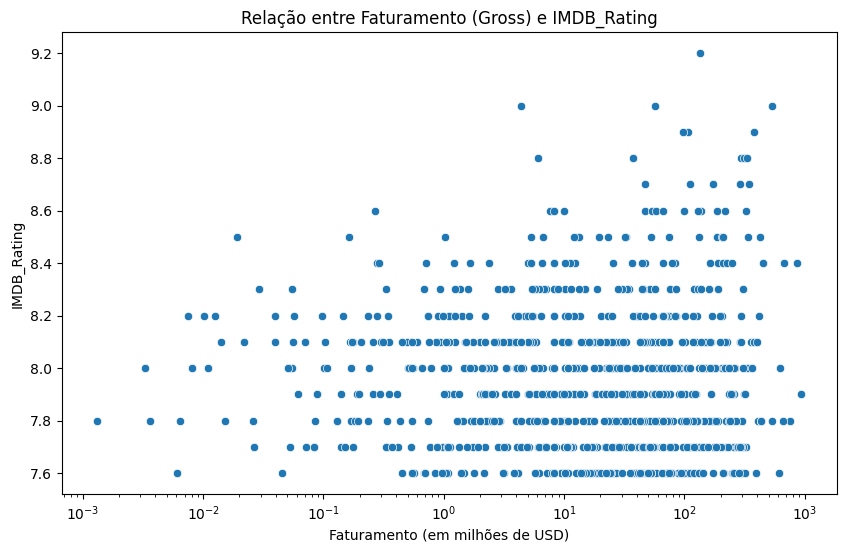


Correlação entre Gross e IMDB_Rating: 0.09


In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Gross', y='IMDB_Rating', data=df_tratado)
plt.title('Relação entre Faturamento (Gross) e IMDB_Rating')
plt.xlabel('Faturamento (em milhões de USD)')
plt.ylabel('IMDB_Rating')
plt.xscale('log')
plt.show()

correlation_gross_rating = df_tratado['Gross'].corr(df_tratado['IMDB_Rating'])
print(f'\nCorrelação entre Gross e IMDB_Rating: {correlation_gross_rating:.2f}')

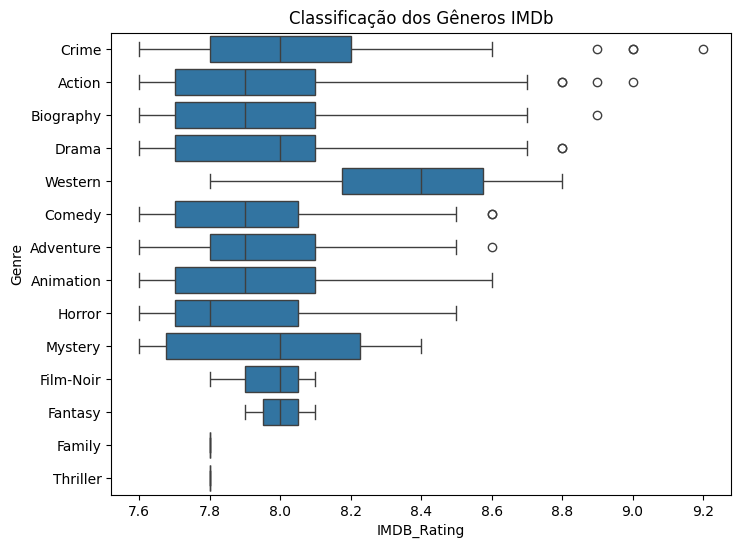

In [289]:
plt.figure(figsize=(8,6))
sns.boxplot(x='IMDB_Rating',y='Genre',data=df_tratado)
plt.title('Classificação dos Gêneros IMDb',fontsize=12)
plt.show()

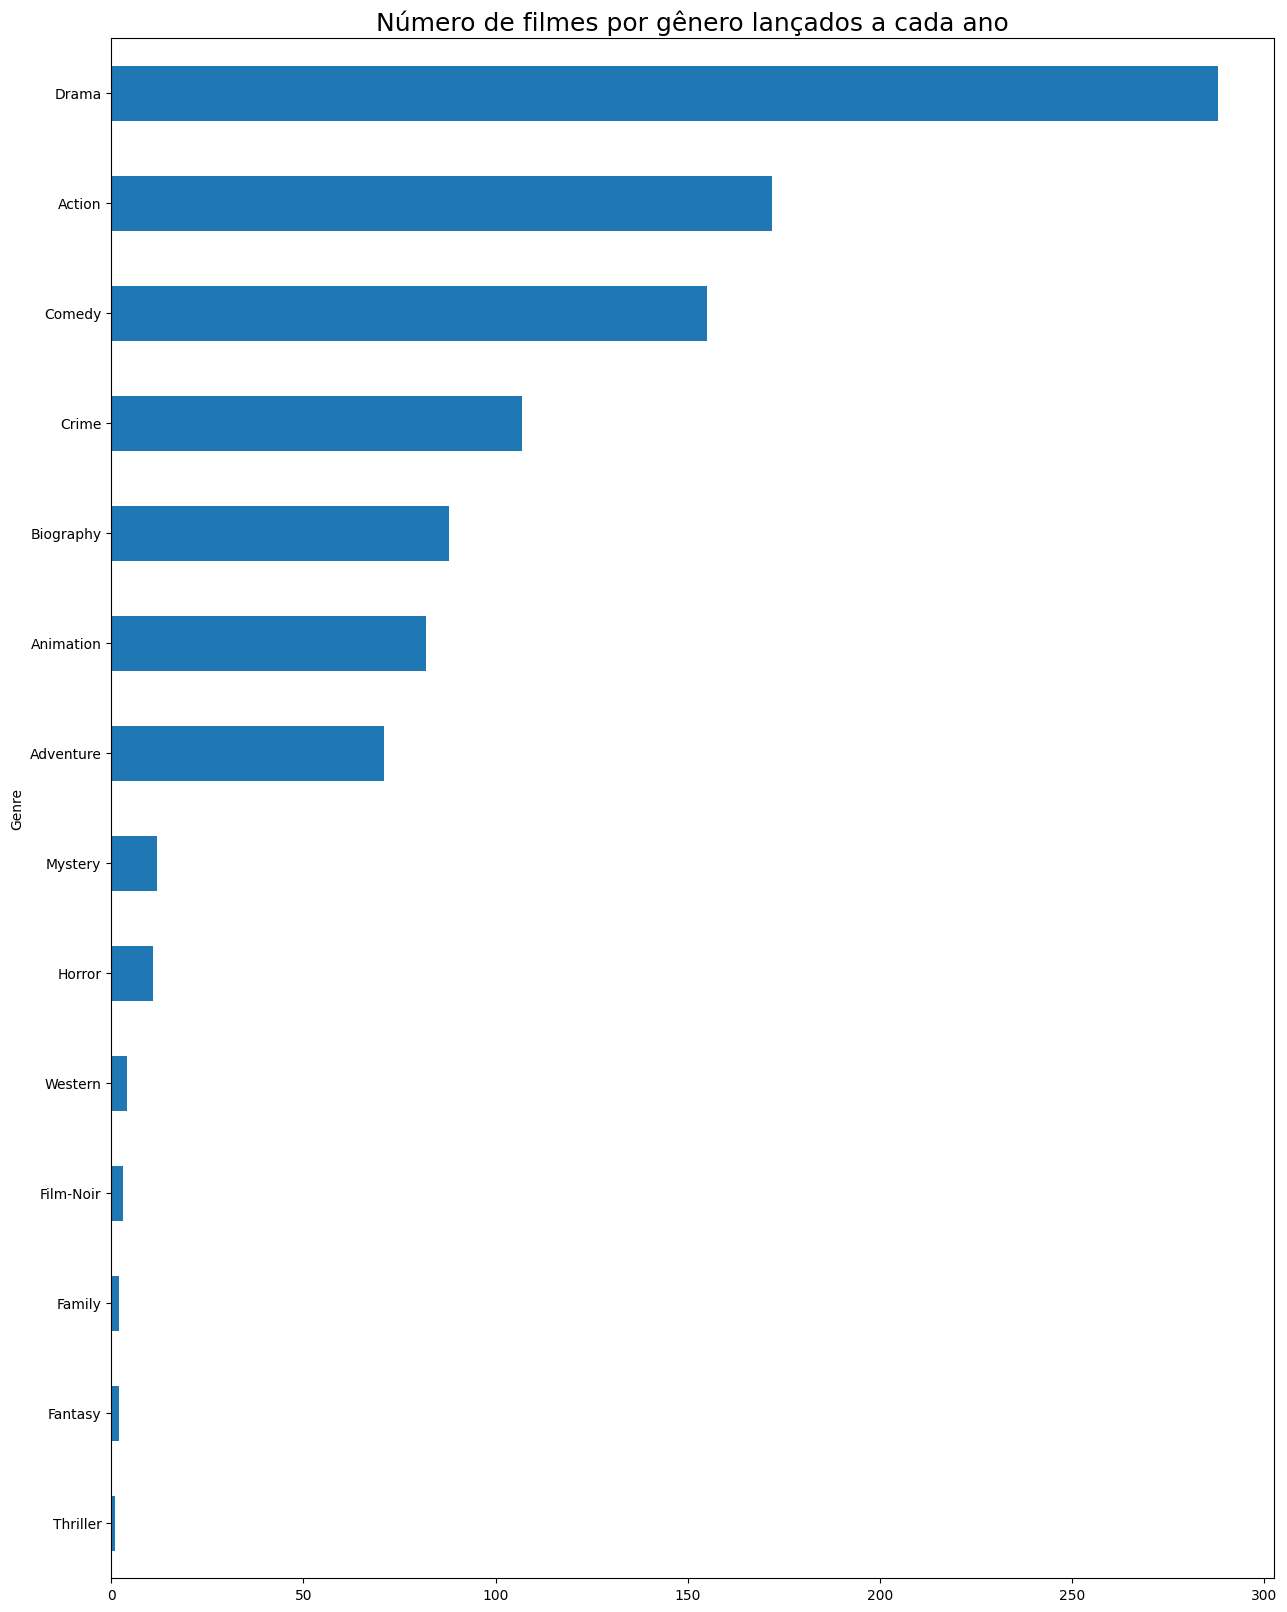

In [296]:
df_tratado.Genre.value_counts(dropna=True).sort_values().plot(kind='barh',figsize=(15,20))
plt.title('Número de filmes por gênero lançados a cada ano',fontsize=18)
plt.show()

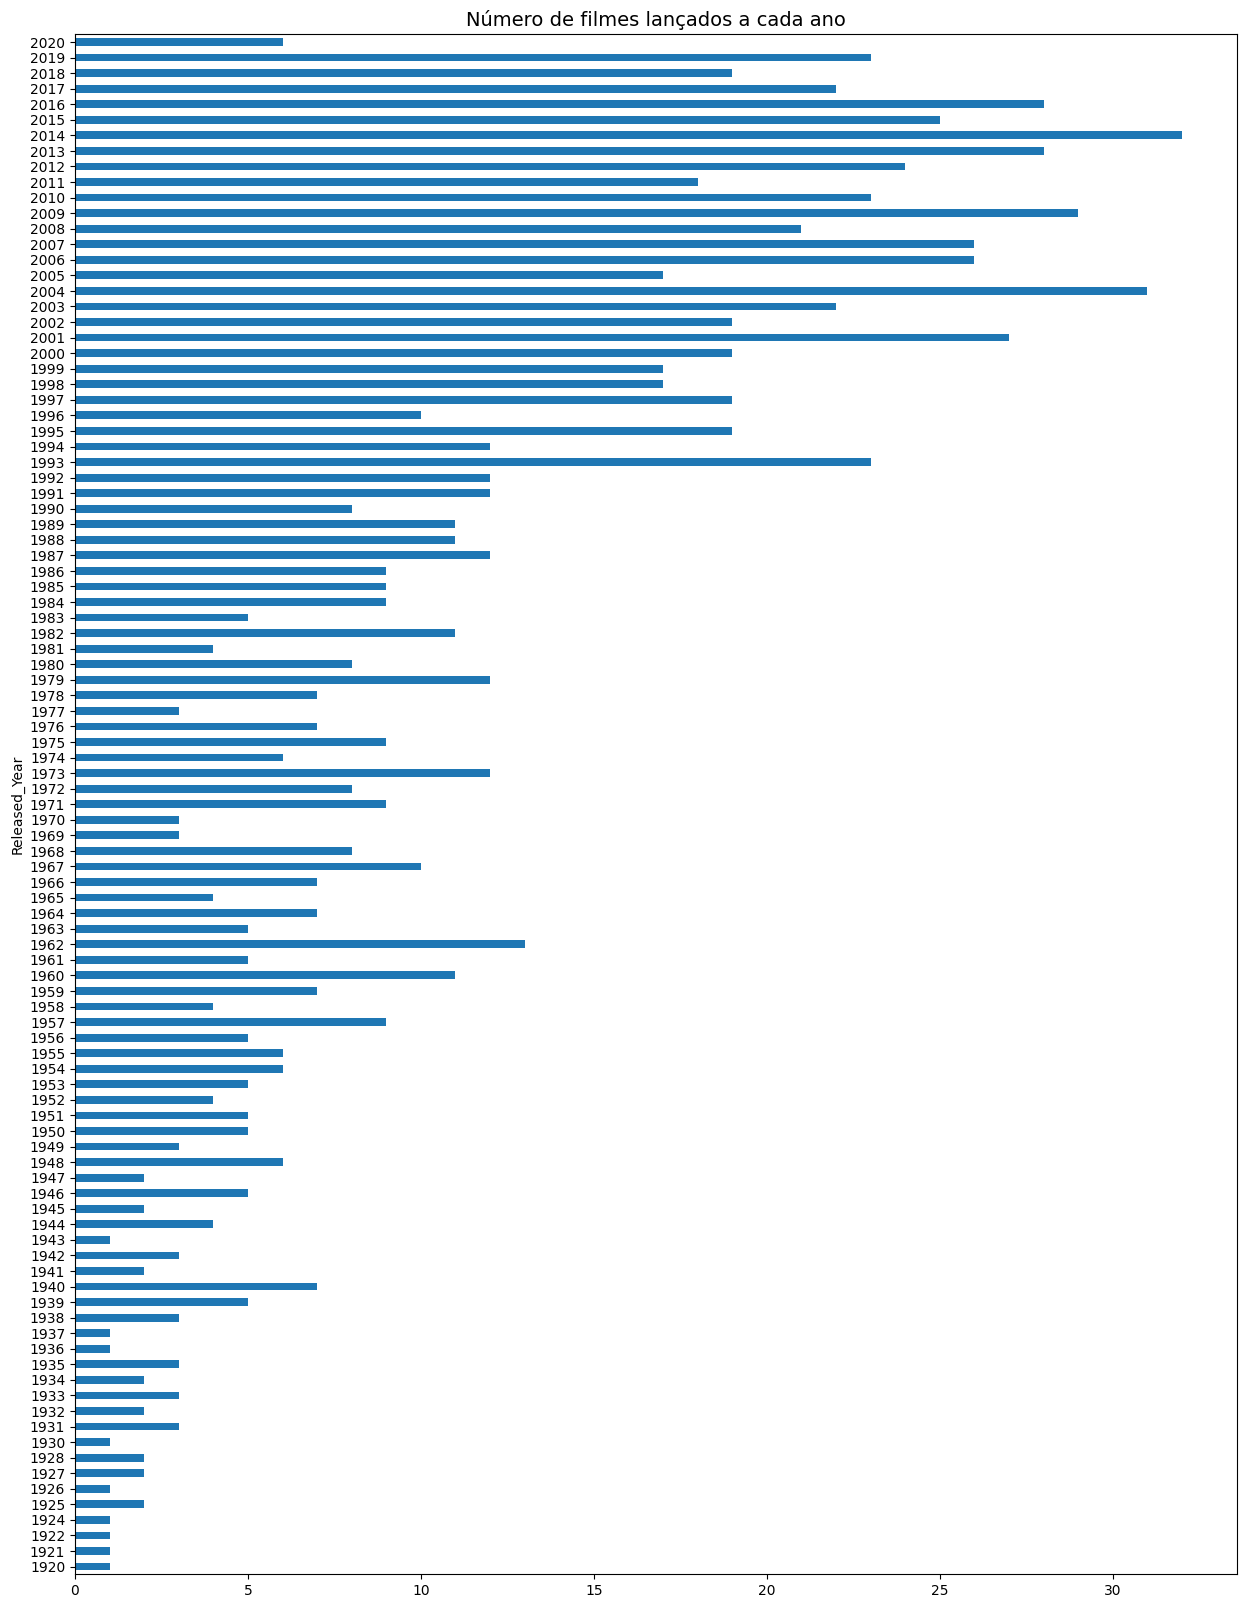

In [294]:
df_tratado.Released_Year.value_counts(dropna=True).sort_index().plot(kind='barh',figsize=(15,20))
plt.title('Número de filmes lançados a cada ano',fontsize=14)
plt.show()

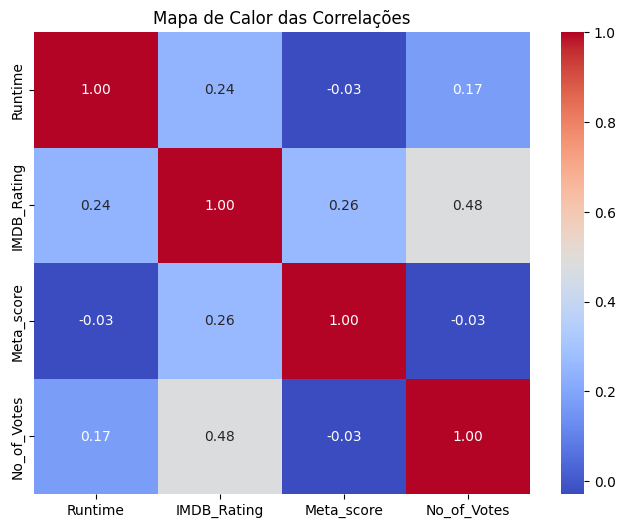

In [252]:
# Correlação entre variáveis
plt.figure(figsize=(8, 6))
sns.heatmap(df_tratado.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Mapa de Calor das Correlações')
plt.show()

No_of_Votes e Meta_Score são os melhores preditores numéricos encontrados.

Text(0.5, 1.0, 'Distribuição das notas IMDb')

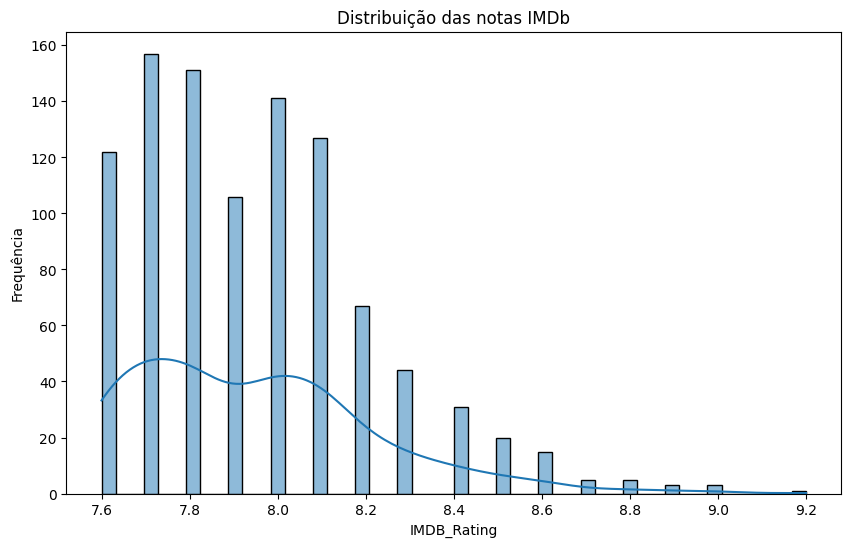

In [253]:
plt.figure(figsize=(10, 6))
sns.histplot(df_tratado['IMDB_Rating'], bins=50, kde=True, edgecolor='black')
plt.ylabel("Frequência")
plt.title('Distribuição das notas IMDb')

In [254]:
df_tratado.describe().transpose()


,count,mean,min,25%,50%,75%,max,std
Released_Year,998,1991-03-20 10:33:25.611222400,1920-01-01 00:00:00,1976-01-01 00:00:00,1999-01-01 00:00:00,2009-01-01 00:00:00,2020-01-01 00:00:00,NaN
Runtime,998.0,122.854709,45.0,103.0,119.0,136.75,321.0,28.110078
IMDB_Rating,998.0,7.948297,7.6,7.7,7.9,8.1,9.2,0.272203
Meta_score,998.0,78.132265,28.0,72.0,79.0,85.75,100.0,11.379412
No_of_Votes,998.0,271623.851703,25088.0,55416.75,138168.5,373506.25,2303232.0,321073.510657


In [255]:
df_tratado.head(3)

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
1,The Godfather,1972-01-01,A,175,Crime,9.2,an organized crime dynasty s aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134.966411
2,The Dark Knight,2008-01-01,UA,152,Action,9.0,when the menace known as the joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534.858444
3,The Godfather: Part II,1974-01-01,A,202,Crime,9.0,the early life and career of vito corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57.3


In [ ]:
if 'Released_Year' in df_tratado.columns:
    
    df_tratado.dropna(subset=['Released_Year'], inplace=True)
    
    df_tratado['Released_Year'] = df_tratado['Released_Year'].dt.year
    
    print("\n--- Criada a feature 'Ano_Lancamento' ---")


--- Criada a feature 'Ano_Lancamento' ---


In [257]:
df_tratado['Released_Year']

1      1972
2      2008
3      1974
4      1957
5      2003
       ... 
995    1961
996    1956
997    1953
998    1944
999    1935
Name: Released_Year, Length: 998, dtype: int32

### Criação de Novas Features

In [258]:
df_tratado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 998 entries, 1 to 999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   998 non-null    object 
 1   Released_Year  998 non-null    int32  
 2   Certificate    998 non-null    object 
 3   Runtime        998 non-null    int64  
 4   Genre          998 non-null    object 
 5   IMDB_Rating    998 non-null    float64
 6   Overview       998 non-null    object 
 7   Meta_score     998 non-null    float64
 8   Director       998 non-null    object 
 9   Star1          998 non-null    object 
 10  Star2          998 non-null    object 
 11  Star3          998 non-null    object 
 12  Star4          998 non-null    object 
 13  No_of_Votes    998 non-null    int64  
 14  Gross          998 non-null    object 
dtypes: float64(2), int32(1), int64(2), object(10)
memory usage: 120.9+ KB


In [259]:
df_final = df_tratado.copy()

In [ ]:
if 'Genre' in df_final.columns:

    df_final['Genre_list'] = df_final['Genre'].str.split(', ')
    all_genres = [genre for sublist in df_final['Genre_list'] for genre in sublist]
    unique_genres = sorted(list(set(all_genres)))

    for genre in unique_genres:
        df_final[f'Genre_{genre}'] = df_final['Genre_list'].apply(lambda x: 1 if genre in x else 0)
    print("\n--- Criadas features 'Genre_...' para cada gênero único ---")
    
    df_final.drop('Genre_list', axis=1, inplace=True)


--- Criadas features 'Genre_...' para cada gênero único ---


In [ ]:
if 'Director' in df_final.columns:
    
    director_counts = df['Director'].value_counts()
    df_final['Director_Frequencia'] = df_final['Director'].map(director_counts)
    print("\n--- Criada a feature 'Director_Frequencia' ---")


    if len(df_final['Director'].unique()) < 1000:
        le = LabelEncoder()
        df_final['Director_Encoded'] = le.fit_transform(df_final['Director'])
        print("\n--- Criada a feature 'Director_Encoded' (Label Encoding) ---")
    else:
        print("\n--- Aviso: Muitos diretores únicos para aplicar Label Encoding diretamente. Considere outras técnicas ou agrupamento. ---")


--- Criada a feature 'Director_Frequencia' ---

--- Criada a feature 'Director_Encoded' (Label Encoding) ---


In [262]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 998 entries, 1 to 999
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Series_Title         998 non-null    object 
 1   Released_Year        998 non-null    int32  
 2   Certificate          998 non-null    object 
 3   Runtime              998 non-null    int64  
 4   Genre                998 non-null    object 
 5   IMDB_Rating          998 non-null    float64
 6   Overview             998 non-null    object 
 7   Meta_score           998 non-null    float64
 8   Director             998 non-null    object 
 9   Star1                998 non-null    object 
 10  Star2                998 non-null    object 
 11  Star3                998 non-null    object 
 12  Star4                998 non-null    object 
 13  No_of_Votes          998 non-null    int64  
 14  Gross                998 non-null    object 
 15  Genre_Action         998 non-null    int64  


In [264]:
df_modelo = df_final.drop(['Series_Title', 'Certificate', 'Genre', 'Overview', 'Director', 'Star1', 'Star2', 'Star3', 'Star4'], axis=1)
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 998 entries, 1 to 999
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Released_Year        998 non-null    int32  
 1   Runtime              998 non-null    int64  
 2   IMDB_Rating          998 non-null    float64
 3   Meta_score           998 non-null    float64
 4   No_of_Votes          998 non-null    int64  
 5   Gross                998 non-null    object 
 6   Genre_Action         998 non-null    int64  
 7   Genre_Adventure      998 non-null    int64  
 8   Genre_Animation      998 non-null    int64  
 9   Genre_Biography      998 non-null    int64  
 10  Genre_Comedy         998 non-null    int64  
 11  Genre_Crime          998 non-null    int64  
 12  Genre_Drama          998 non-null    int64  
 13  Genre_Family         998 non-null    int64  
 14  Genre_Fantasy        998 non-null    int64  
 15  Genre_Film-Noir      998 non-null    int64  


In [266]:
target = 'IMDB_Rating' if 'IMDB_Rating' in df_modelo.columns else 'IMDB Rating'
y = df_modelo[target]
X = df_modelo.drop(['IMDB_Rating'], axis=1)


In [267]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [268]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
results = {}

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
results['Linear Regression'] = {
    'MAE': mean_absolute_error(y_test, y_pred_lr),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lr)),
    'R2': r2_score(y_test, y_pred_lr)
}

In [ ]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
results['Decision Tree'] = {
    'MAE': mean_absolute_error(y_test, y_pred_dt),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_dt)),
    'R2': r2_score(y_test, y_pred_dt)
}

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
results['Random Forest'] = {
    'MAE': mean_absolute_error(y_test, y_pred_rf),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    'R2': r2_score(y_test, y_pred_rf)
}

In [ ]:
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
results['Gradient Boosting'] = {
    'MAE': mean_absolute_error(y_test, y_pred_gb),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_gb)),
    'R2': r2_score(y_test, y_pred_gb)
}


Comparacao dos Modelos:
                        MAE      RMSE        R2
Gradient Boosting  0.154853  0.198370  0.449825
Random Forest      0.157772  0.201897  0.430089
Linear Regression  0.172676  0.214600  0.356113
Decision Tree      0.205600  0.265631  0.013478


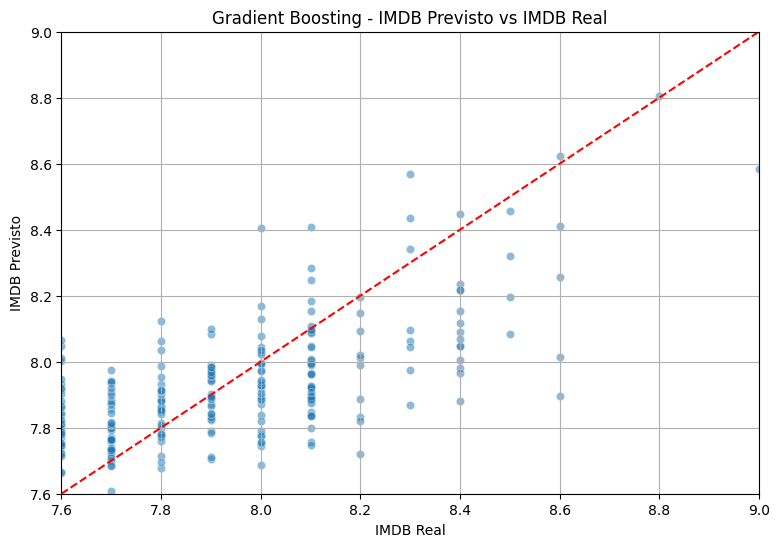

In [ ]:
results_df = pd.DataFrame(results).T.sort_values(by='RMSE')
print("\nComparacao dos Modelos:")
print(results_df)

best_model = results_df.index[0]
y_best = {
    'Linear Regression': y_pred_lr,
    'Decision Tree': y_pred_dt,
    'Random Forest': y_pred_rf,
    'Gradient Boosting': y_pred_gb

}[best_model]

plt.figure(figsize=(9, 6))
sns.scatterplot(x=y_test, y=y_best, alpha=0.5)
min_val = min(y_test.min(), y_best.min())
max_val = max(y_test.max(), y_best.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.xlabel("IMDB Real")
plt.ylabel("IMDB Previsto")
plt.title(f"{best_model} - IMDB Previsto vs IMDB Real")
plt.grid(True)
plt.show()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Cálculo do VIF
X_vif = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["Variável"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print("\nVIF (Variance Inflation Factor):")
print(vif_data)

C:\Users\ronal\AppData\Local\Temp\ipykernel_33168\2213961222.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


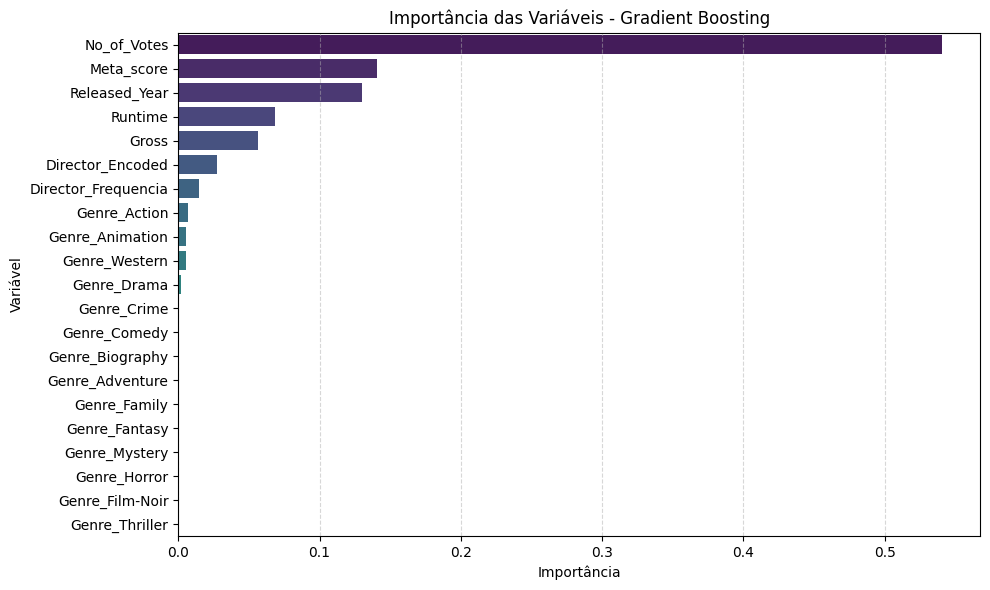

In [ ]:
model_gb = GradientBoostingRegressor(random_state=42)
model_gb.fit(X_train, y_train)

importances = model_gb.feature_importances_
features = X_train.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Importância das Variáveis - Gradient Boosting')
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show()

In [281]:
new_movie_data = pd.DataFrame([{
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': '1994',
    'Certificate': 'A',
    'Runtime': '142 min',
    'Genre': 'Drama',
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': '28,341,469'
}])


new_movie_data['Runtime'] = new_movie_data['Runtime'].str.replace(' min', '').astype(float)

new_movie_data['Gross'] = new_movie_data['Gross'].str.replace(',', '', regex=True).astype(float)

new_movie_data['Released_Year'] = pd.to_numeric(new_movie_data['Released_Year'], errors='coerce')

all_genres = set(genre for genres in df['Genre'].str.split(', ') for genre in genres)

for genre in all_genres:
    new_movie_data[f'Genre_{genre}'] = new_movie_data['Genre'].apply(lambda x: 1 if genre in x else 0)

new_movie_data = new_movie_data.drop('Genre', axis=1)


if 'Director' in new_movie_data.columns:

    director_counts = df['Director'].value_counts()
    new_movie_data['Director_Frequencia'] = new_movie_data['Director'].map(director_counts)


    if len(new_movie_data['Director'].unique()) < 1000:
        le = LabelEncoder()
        new_movie_data['Director_Encoded'] = le.fit_transform(new_movie_data['Director'])


features_to_predict = X_train.columns
new_movie_processed = new_movie_data[features_to_predict]

predicted_imdb_rating = model_gb.predict(new_movie_processed)

print(f"A nota do IMDB prevista para 'The Shawshank Redemption' é: {predicted_imdb_rating[0]:.2f}")

A nota do IMDB prevista para 'The Shawshank Redemption' é: 8.58


In [ ]:
import pickle

filename = 'modelo_imdb_gb.pkl'

with open(filename, 'wb') as file:
    pickle.dump(model_gb, file)

print(f'Modelo salvo com sucesso em '{filename}'!')


Modelo salvo com sucesso em 'modelo_imdb_gb.pkl'!
